# Comparing one way vs two way perfect commuting $R_0$
Summary: Simple model estimates $R_0$ correctly when fitted to data simulated from 2-way perfect model.

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from model import simulate, two_way_to_one_way, two_way_r0
from basic_epidemic import calculate_r0 as oneway_r0
import matplotlib as mpl
import matplotlib.pyplot as plt
from grab_data import *
from basic_epidemic import fit_model
from itertools import product

mpl.rcParams['figure.dpi'] = 300

In [12]:
DATASET = 'CENSUS_SUBSAMPLED'
flow_matrix = get_matrix(DATASET)
population_sizes = get_population_sizes(DATASET)
population_names = get_population_ordering(DATASET)

two_way_params = dict(beta=1.8, gamma=0.2, tau_0=9 / 24,
                      tau_1=17 / 24)
one_way_params = two_way_to_one_way(**two_way_params, od_matrix=flow_matrix, pop_sizes=population_sizes)
one_way_params

{'beta': 4.635714497926086, 'gamma': 0.2, 'psi': 0.33333333333333337}

In [13]:
oneway_sim = simulate(od_matrix=flow_matrix, pop_sizes=population_sizes, model='random_oneway', **one_way_params)
twoway_sim = simulate(od_matrix=flow_matrix, pop_sizes=population_sizes, model='perfect', **two_way_params)

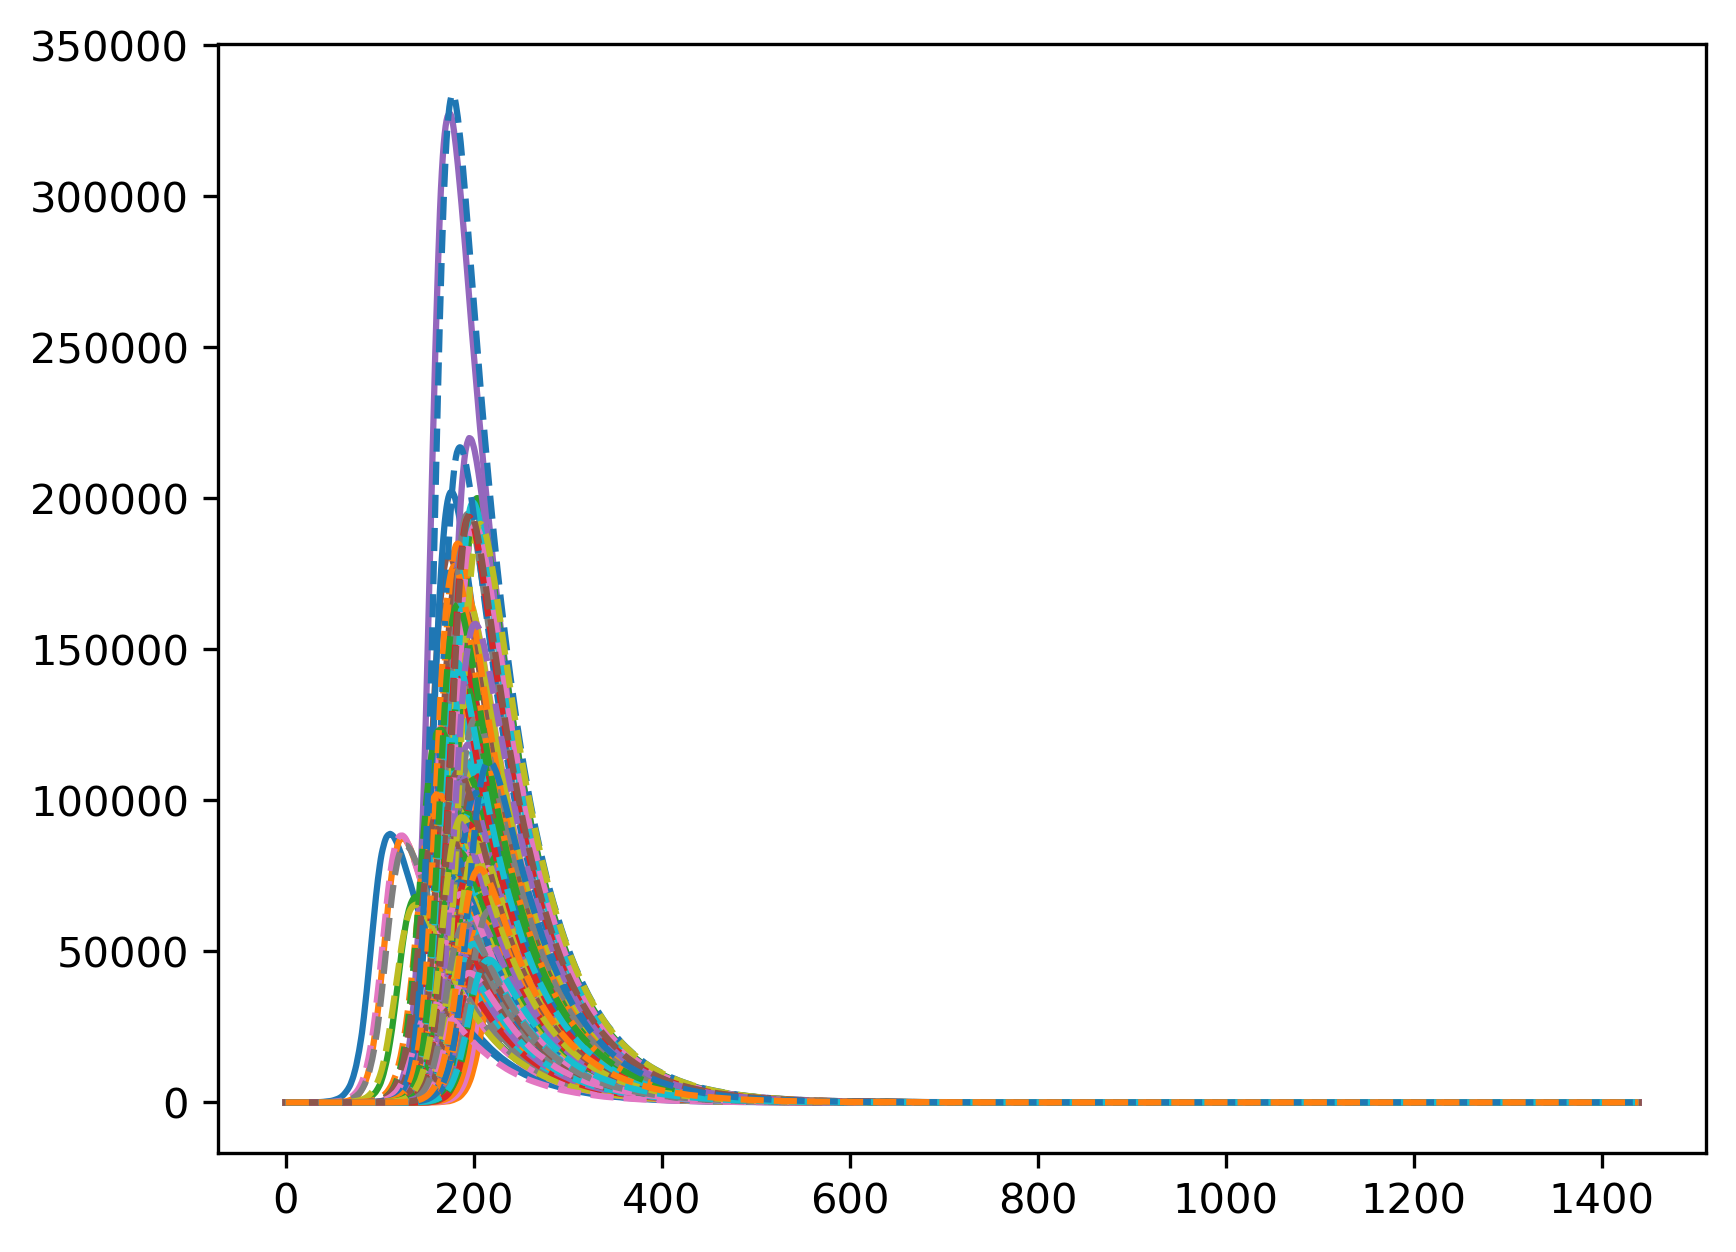

In [14]:
plt.plot(twoway_sim[1].sum(axis=2))
plt.plot(oneway_sim[1].sum(axis=2), linestyle='--')
plt.show()

In [15]:
fit_params = fit_model((twoway_sim[0].sum(axis=2), twoway_sim[1].sum(axis=2), twoway_sim[2].sum(axis=2)), flow_matrix,
                       population_sizes, t_delta=1 / 12)
fit_params

(2.272542403582609, 0.19998420525126354, 0.7821646268502869)

In [16]:
oneway_r0(**one_way_params, flow_matrix=flow_matrix, population_sizes=population_sizes)

9.113395552839439

In [17]:
two_way_r0(**two_way_params, od_matrix=flow_matrix, pop_sizes=population_sizes)

9.0

In [18]:
oneway_r0(beta=fit_params[0], gamma=fit_params[1], psi=fit_params[2], flow_matrix=flow_matrix,
          population_sizes=population_sizes)

9.110436765296715

In [101]:
def simulate_and_fit(od_matrix, pop_sizes, t_delta=1 / 12):
    true_params = list(product(np.linspace(1, 3, 8), np.linspace(0.2, 0.8, 5)))
    true_r0 = []
    est_r0 = []
    tau_0, tau_1 = 9 / 24, 17 / 24
    total_pop = pop_sizes.sum()
    for b, g in true_params:
        true_params = dict(beta=b, gamma=g, tau_0=tau_0, tau_1=tau_1)
        sim_data = simulate(**true_params, od_matrix=od_matrix,
                            pop_sizes=pop_sizes, model='perfect')
        # not interested in extinctions
        while sim_data[1].sum(axis=(0, 1, 2)) / total_pop <= 0.05:
            sim_data = simulate(**true_params, od_matrix=od_matrix,
                                pop_sizes=pop_sizes, model='perfect')
        flattened_sim = sim_data[0].sum(axis=2), sim_data[1].sum(axis=2), sim_data[2].sum(axis=2)
        true_r0.append(two_way_r0(**true_params, od_matrix=od_matrix, pop_sizes=pop_sizes))
        b_hat, g_hat, psi_hat = fit_model(flattened_sim, od_matrix, pop_sizes, t_delta=t_delta)
        est_r0.append(oneway_r0(beta=b_hat, gamma=g_hat, psi=psi_hat, flow_matrix=od_matrix,
                                population_sizes=pop_sizes))

    return np.array(true_r0), np.array(est_r0)

In [102]:
res = simulate_and_fit(od_matrix=flow_matrix, pop_sizes=population_sizes, t_delta=1 / 12)

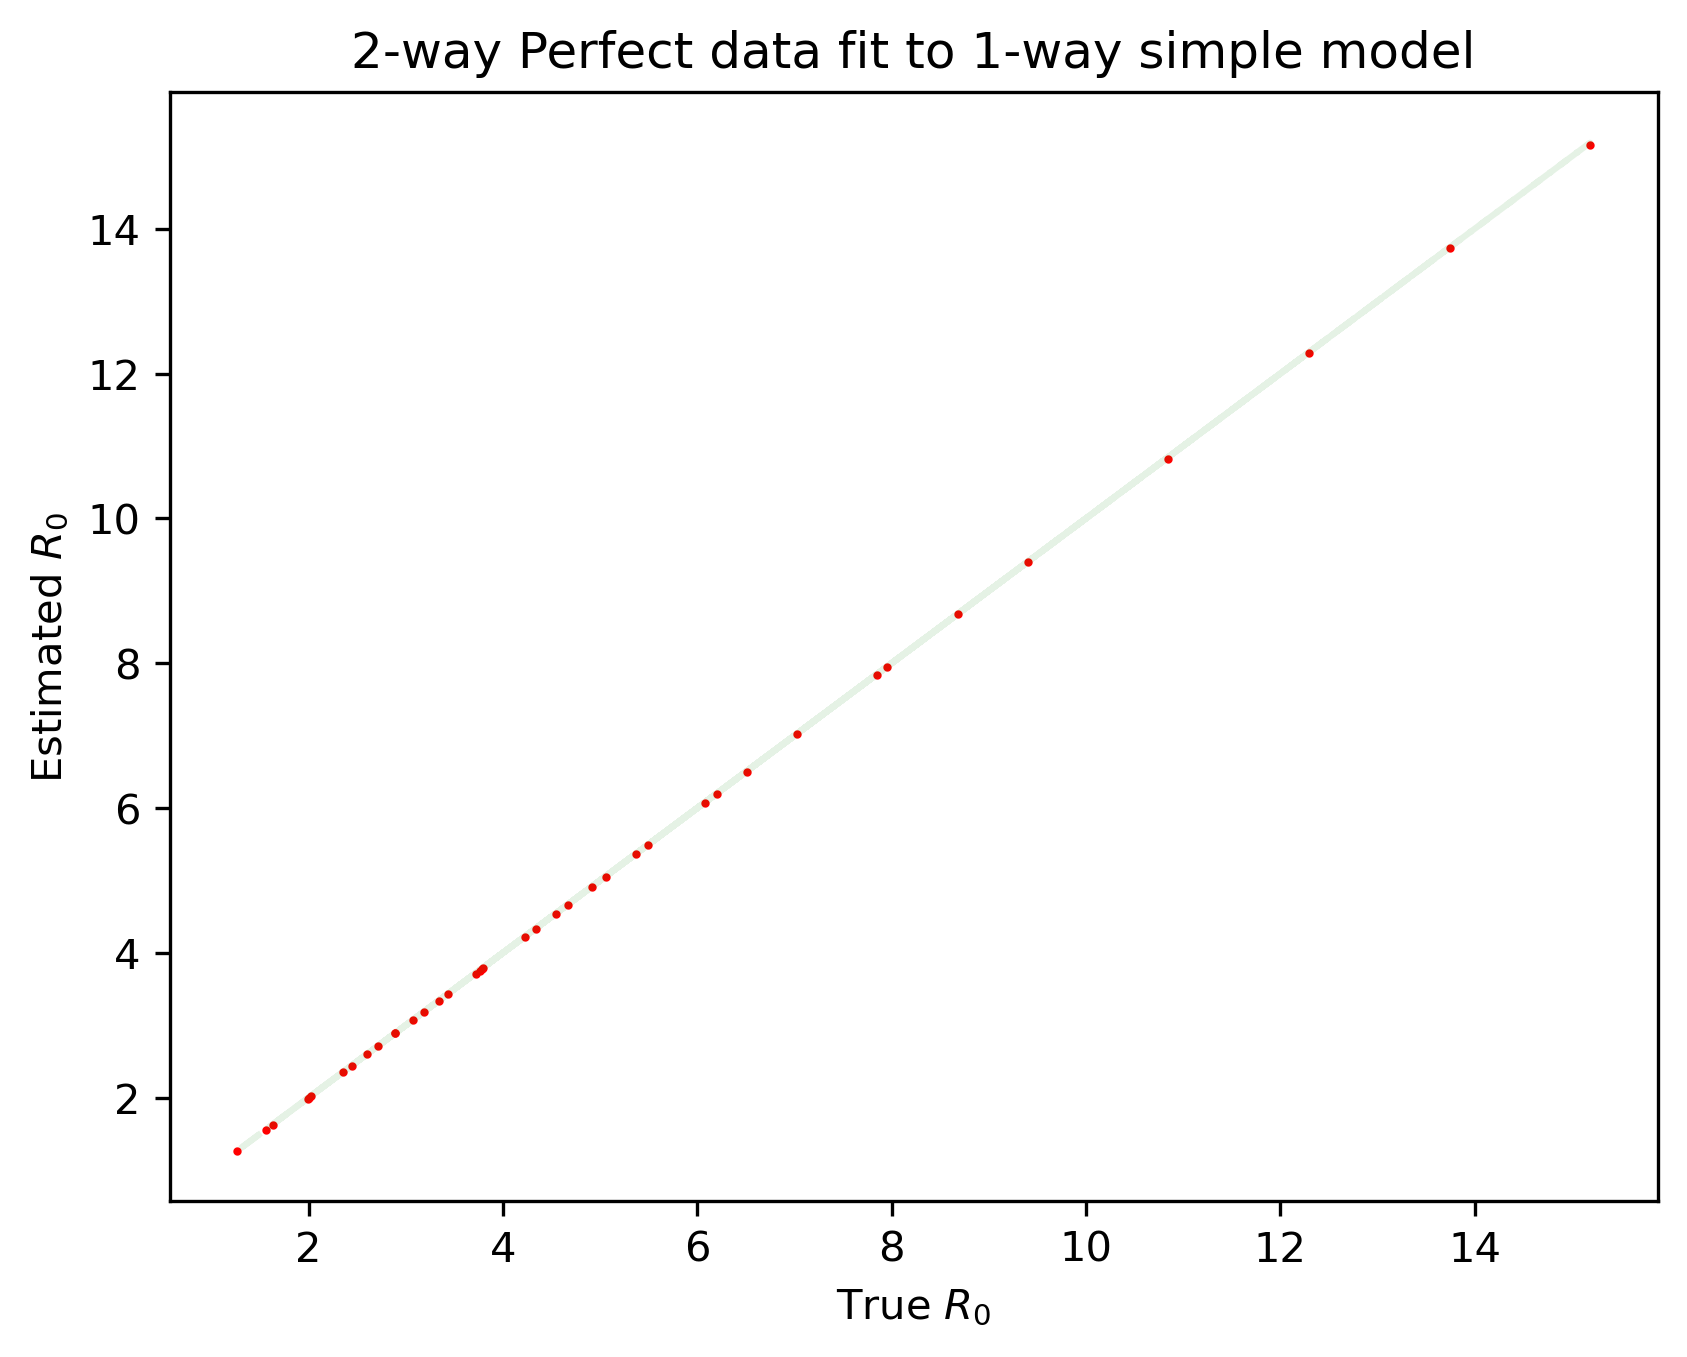

In [114]:
plt.plot(res[0], res[0], c='green', linestyle='--', alpha=0.1)
plt.scatter(*res, s=1, c='r')
plt.xlabel('True $R_0$')
plt.title('2-way Perfect data fit to 1-way simple model')
plt.ylabel('Estimated $R_0$')
plt.show()